# Projeto #1 - Regressão

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

%run modules/text.py

%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [2]:
df = pd.read_csv('dataset/regressor_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 1635078 | Coluna:  24


### Remove variáveis possíveis outliers
> Condutores com mais de 100 e menos de 10 anos

In [3]:
df['outlier'] = df.apply(lambda x: identifierConductorsOver100OrUnder10YearsOld(x.tipo_envolvido, x.idade), axis=1)
df.drop(df[df['outlier'] == 'outlier'].index, inplace=True)

### Remove os indivíduos não expostos ao risco de morte

In [4]:
df.drop(df[df['estado_fisico'] == 'ileso'].index, inplace=True)
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 495313 | Coluna:  25


### Definição da variável resposta

In [5]:
df['estado_fisico'] = df['estado_fisico'].map({'morto': 'morto', 'ferido leve': 'sobrevivente', 'ferido grave': 'sobrevivente'})
round(df['estado_fisico'].value_counts(normalize=True)*100, 2)

sobrevivente    93.87
morto            6.13
Name: estado_fisico, dtype: float64

### Geração de features

Causa presumível do acidente com base nas características

In [6]:
df['causa_presumivel_acidente'] = df['causa_acidente'].apply(mapCausaAcidentes)

Define o horário do acidente

In [7]:
df['horario_acidente'] = df['horario'].apply(mapHorarioAcidentes)

Categorização do ano de fabricação do veículo com base na data do acidente

In [8]:
labels = ['ate dez anos', 'mais de dez anos']
classes = [0, 10, 170]

df['tempo_fabricacao_no_ano_do_acidente'] = df['ano'] - df['ano_fabricacao_veiculo']
df['faixa_ano_fabricacao'] = pd.cut(x=df['tempo_fabricacao_no_ano_do_acidente'], bins=classes, labels=labels, include_lowest=True)

Agrupamento tipo de envolvido

In [9]:
df['tipo_envolvido'] = df.apply(lambda x: mapTipoEnvolvido(x.tipo_veiculo, x.tipo_envolvido), axis=1)

Combinação das variáveis tipo de veículo e tipo de envolvido

> Identifica a forma como se deu a participação da vítima no acidente

In [10]:
df['condicao_envolvimento'] = df.apply(lambda x: mapCondicaoEnvolvimento(x.tipo_envolvido, x.tipo_veiculo), axis=1)
df.drop(df[df['condicao_envolvimento'] == 'outros'].index, inplace=True)

Agrupamento dos tipos de acidentes

In [11]:
df['tipo_acidente'] = df['tipo_acidente'].apply(mapTiposDeAcidentes)

Agrupamento traçado da via

In [12]:
df['tracado_via'] = df['tracado_via'].apply(mapTracadoVia)

Agrupamento idade

In [13]:
labels = ['0-14', '15-30', '30-44', '45-59', '60+']
classes = [0, 14, 30, 44, 59, 99]
df['faixa_etaria'] = pd.cut(x=df['idade'], bins=classes, labels=labels, include_lowest=True)

### Seleção de features

In [14]:
colunas = [
    'sexo',
    'faixa_etaria',
    'condicao_envolvimento',
    'tipo_acidente',
    'tipo_pista',
    'tracado_via',    
    'dia_semana',
    'horario_acidente',
    'uso_solo',
    'regiao_pais',
    'faixa_ano_fabricacao',
    'causa_presumivel_acidente',
    'estado_fisico'
]
dados = df[colunas]
print(f'Linhas: {dados.shape[0]} | Coluna:  {dados.shape[1]}')
dados.head(1)

Linhas: 495173 | Coluna:  13


,sexo,faixa_etaria,condicao_envolvimento,tipo_acidente,tipo_pista,tracado_via,dia_semana,horario_acidente,uso_solo,regiao_pais,faixa_ano_fabricacao,causa_presumivel_acidente,estado_fisico
8,masculino,30-44,ocupante de motocicleta,colisao traseira,simples,reta,quarta,madrugada,urbano,centro-oeste,ate dez anos,outros aspectos não identificados,sobrevivente


### Distribuição das variáveis explicativas

In [15]:
for col in dados.columns:
    print(round(dados[col].value_counts(normalize=True)*100, 2))
    print('---------------------------------')

masculino    84.58
feminino     15.42
Name: sexo, dtype: float64
---------------------------------
15-30    40.11
30-44    34.52
45-59    18.65
60+       6.27
0-14      0.45
Name: faixa_etaria, dtype: float64
---------------------------------
ocupante de motocicleta              37.14
ocupante de automóveis               35.28
ocupante de caminhão                 13.38
ocupante de caminhonete/camioneta     7.94
ocupante de motoneta                  4.05
pedestre                              1.33
ocupante de micro-ônibus/ônibus       0.80
ciclista                              0.08
Name: condicao_envolvimento, dtype: float64
---------------------------------
saída da pista              20.10
capotamento/tombamento      16.53
colisao traseira            12.79
colisao transversal         10.77
queda de veículo             9.89
colisao lateral              9.71
outros                       7.52
colisao frontal              7.48
atropelamento de pessoas     2.54
atropelamento de animal      

### Regressão logística binomial

> Para todos os testes será empregado o nível de confiança de 95%, ou seja, p-valor < 0.05 indica que os coeficientes estimados foram estatisticamente significativos

Testando interação entre sexo e idade

In [16]:
model = smf.glm(formula='estado_fisico ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente+tipo_pista+tracado_via+dia_semana+horario_acidente+uso_solo+regiao_pais+faixa_ano_fabricacao+causa_presumivel_acidente+sexo*faixa_etaria', 
                 data=dados, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Generalized Linear Model Regression Results                                    
===================================================================================================================
Dep. Variable:     ['estado_fisico[morto]', 'estado_fisico[sobrevivente]']   No. Observations:               495173
Model:                                                                 GLM   Df Residuals:                   495123
Model Family:                                                     Binomial   Df Model:                           49
Link Function:                                                       Logit   Scale:                          1.0000
Method:                                                               IRLS   Log-Likelihood:                -99211.
Date:                                                     Tue, 15 Feb 2022   Deviance:                   1.9842e+05
Time:                                                             06:42:27   Pearson chi2:                 4.82e+05
No. Iterations:                                                          7   Pseudo R-squ. (CS):            0.05854
Covariance Type:                                                 nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          -2.5725      0.274     -9.399      0.000      -3.109      -2.036
sexo[T.masculino]                                                                   0.0624      0.258      0.242      0.808      -0.442       0.567
faixa_etaria[T.15-30]                                                               0.1326      0.200      0.664      0.506      -0.259       0.524
faixa_etaria[T.30-44]                                                               0.3026      0.200      1.515      0.130      -0.089       0.694
faixa_etaria[T.45-59]                                                               0.4982      0.202      2.467      0.014       0.102       0.894
faixa_etaria[T.60+]                                                                 0.8914      0.208      4.290      0.000       0.484       1.299
condicao_envolvimento[T.ocupante de automóveis]                                    -1.4537      0.179     -8.138      0.000      -1.804      -1.104
condicao_envolvimento[T.ocupante de caminhonete/camioneta]                         -1.4665      0.180     -8.163      0.000      -1.819      -1.114
condicao_envolvimento[T.ocupante de caminhão]                                      -1.0797      0.179     -6.031      0.000      -1.431      -0.729
condicao_envolvimento[T.ocupante de micro-ônibus/ônibus]                           -1.6495      0.192     -8.590      0.000      -2.026      -1.273
condicao_envolvimento[T.ocupante de motocicleta]                                   -0.8320      0.178     -4.663      0.000      -1.182      -0.482
condicao_envolvimento[T.ocupante de motoneta]                                      -1.0682      0.183     -5.832      0.000      -1.427      -0.709
condicao_envolvimento[T.pedestre]                                                   1.0603      0.188      5.629      0.000       0.691       1.430
tipo_acidente[T.atropelamento de pessoas]                                          -0.4162      0.080     -5.201      0.000      -0.573      -0.259
tipo_acidente[T.capotamento/tombamento]                                            -0.5225      0.059     -8.860      0.000      -0.638      -0.407
tipo_acident

> <p style='text-align: justify;'><font size=2.85>O p-valor indica que não existe efeito de interação entre as variáveis sexo e idade.<font size=2.85></font></p>

Testando interação entre condição de envolvimento e sexo

In [17]:
model = smf.glm(formula='estado_fisico ~ sexo+condicao_envolvimento+tipo_acidente+tipo_pista+tracado_via+dia_semana+horario_acidente+uso_solo+regiao_pais+faixa_ano_fabricacao+causa_presumivel_acidente+sexo*condicao_envolvimento', 
                 data=dados, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Generalized Linear Model Regression Results                                    
===================================================================================================================
Dep. Variable:     ['estado_fisico[morto]', 'estado_fisico[sobrevivente]']   No. Observations:               495173
Model:                                                                 GLM   Df Residuals:                   495124
Model Family:                                                     Binomial   Df Model:                           48
Link Function:                                                       Logit   Scale:                          1.0000
Method:                                                               IRLS   Log-Likelihood:                -99613.
Date:                                                     Tue, 15 Feb 2022   Deviance:                   1.9923e+05
Time:                                                             06:43:01   Pearson chi2:                 4.85e+05
No. Iterations:                                                          7   Pseudo R-squ. (CS):            0.05701
Covariance Type:                                                 nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          -2.6206      1.028     -2.549      0.011      -4.636      -0.605
sexo[T.masculino]                                                                   0.9982      1.041      0.959      0.337      -1.041       3.038
condicao_envolvimento[T.ocupante de automóveis]                                    -1.1232      1.026     -1.094      0.274      -3.135       0.889
condicao_envolvimento[T.ocupante de caminhonete/camioneta]                         -0.9426      1.029     -0.916      0.360      -2.959       1.074
condicao_envolvimento[T.ocupante de caminhão]                                      -0.4606      1.035     -0.445      0.656      -2.488       1.567
condicao_envolvimento[T.ocupante de micro-ônibus/ônibus]                           -1.0522      1.050     -1.002      0.316      -3.110       1.006
condicao_envolvimento[T.ocupante de motocicleta]                                   -0.6659      1.027     -0.648      0.517      -2.679       1.348
condicao_envolvimento[T.ocupante de motoneta]                                      -0.9144      1.030     -0.888      0.375      -2.933       1.104
condicao_envolvimento[T.pedestre]                                                   1.5868      1.030      1.541      0.123      -0.431       3.605
tipo_acidente[T.atropelamento de pessoas]                                          -0.4188      0.080     -5.263      0.000      -0.575      -0.263
tipo_acidente[T.capotamento/tombamento]                                            -0.5380      0.059     -9.130      0.000      -0.654      -0.423
tipo_acidente[T.colisao com bicicleta]                                             -1.3040      0.157     -8.324      0.000      -1.611      -0.997
tipo_acidente[T.colisao frontal]                                                    1.4657      0.058     25.457      0.000       1.353       1.579
tipo_acidente[T.colisao lateral]                                                   -0.1966      0.061     -3.245      0.001      -0.315      -0.078
tipo_acidente[T.colisao transversal]                                                0.0249      0.061      0.411      0.681      -0.094       0.144
tipo_acident

> <p style='text-align: justify;'><font size=2.85>O p-valor indica que o efeito de interação entre as variáveis condição de envolvimento e sexo não é estatisticamente significativo.</font></p>

Testando interação entre tipo de pista e tipo de acidente

In [18]:
model = smf.glm(formula='estado_fisico ~ tipo_acidente+tipo_pista+tracado_via+dia_semana+horario_acidente+uso_solo+regiao_pais+faixa_ano_fabricacao+causa_presumivel_acidente+tipo_acidente*tipo_pista', 
                 data=dados, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Generalized Linear Model Regression Results                                    
===================================================================================================================
Dep. Variable:     ['estado_fisico[morto]', 'estado_fisico[sobrevivente]']   No. Observations:               495173
Model:                                                                 GLM   Df Residuals:                   495119
Model Family:                                                     Binomial   Df Model:                           53
Link Function:                                                       Logit   Scale:                          1.0000
Method:                                                               IRLS   Log-Likelihood:            -1.0130e+05
Date:                                                     Tue, 15 Feb 2022   Deviance:                   2.0260e+05
Time:                                                             06:43:34   Pearson chi2:                 4.82e+05
No. Iterations:                                                          7   Pseudo R-squ. (CS):            0.05056
Covariance Type:                                                 nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          -2.8105      0.110    -25.549      0.000      -3.026      -2.595
tipo_acidente[T.atropelamento de pessoas]                                           1.1748      0.111     10.582      0.000       0.957       1.392
tipo_acidente[T.capotamento/tombamento]                                            -0.6880      0.108     -6.381      0.000      -0.899      -0.477
tipo_acidente[T.colisao com bicicleta]                                             -1.5304      0.371     -4.128      0.000      -2.257      -0.804
tipo_acidente[T.colisao frontal]                                                    1.1548      0.117      9.906      0.000       0.926       1.383
tipo_acidente[T.colisao lateral]                                                   -0.7108      0.117     -6.095      0.000      -0.939      -0.482
tipo_acidente[T.colisao transversal]                                               -0.2552      0.117     -2.186      0.029      -0.484      -0.026
tipo_acidente[T.colisao traseira]                                                  -0.4409      0.108     -4.070      0.000      -0.653      -0.229
tipo_acidente[T.outros]                                                            -0.1913      0.108     -1.766      0.077      -0.404       0.021
tipo_acidente[T.queda de veículo]                                                  -0.7194      0.111     -6.458      0.000      -0.938      -0.501
tipo_acidente[T.saída da pista]                                                    -0.4433      0.106     -4.165      0.000      -0.652      -0.235
tipo_pista[T.multipla]                                                             -0.4360      0.464     -0.939      0.348      -1.346       0.474
tipo_pista[T.simples]                                                               0.2449      0.107      2.284      0.022       0.035       0.455
tracado_via[T.curva]                                                                0.3430      0.047      7.345      0.000       0.251       0.434
tracado_via[T.outros]                                                              -0.0120      0.060     -0.201      0.841      -0.129       0.105
tracado_via[

> <p style='text-align: justify;'>O p-valor indica que o efeito de interação entre as variáveis tipo de pista e tipo de acidente não é estatisticamente significativo.<font size=2.85></font></p>

Modelo final

In [19]:
model = smf.glm(formula='estado_fisico ~ sexo+faixa_etaria+condicao_envolvimento+tipo_acidente+tipo_pista+tracado_via+dia_semana+horario_acidente+uso_solo+regiao_pais+faixa_ano_fabricacao+causa_presumivel_acidente', 
                 data=dados, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Generalized Linear Model Regression Results                                    
===================================================================================================================
Dep. Variable:     ['estado_fisico[morto]', 'estado_fisico[sobrevivente]']   No. Observations:               495173
Model:                                                                 GLM   Df Residuals:                   495127
Model Family:                                                     Binomial   Df Model:                           45
Link Function:                                                       Logit   Scale:                          1.0000
Method:                                                               IRLS   Log-Likelihood:                -99214.
Date:                                                     Tue, 15 Feb 2022   Deviance:                   1.9843e+05
Time:                                                             06:44:06   Pearson chi2:                 4.82e+05
No. Iterations:                                                          7   Pseudo R-squ. (CS):            0.05853
Covariance Type:                                                 nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          -2.8982      0.230    -12.596      0.000      -3.349      -2.447
sexo[T.masculino]                                                                   0.5749      0.024     24.075      0.000       0.528       0.622
faixa_etaria[T.15-30]                                                               0.4863      0.128      3.787      0.000       0.235       0.738
faixa_etaria[T.30-44]                                                               0.6336      0.128      4.936      0.000       0.382       0.885
faixa_etaria[T.45-59]                                                               0.8263      0.129      6.428      0.000       0.574       1.078
faixa_etaria[T.60+]                                                                 1.1074      0.129      8.552      0.000       0.854       1.361
condicao_envolvimento[T.ocupante de automóveis]                                    -1.4510      0.179     -8.124      0.000      -1.801      -1.101
condicao_envolvimento[T.ocupante de caminhonete/camioneta]                         -1.4639      0.180     -8.149      0.000      -1.816      -1.112
condicao_envolvimento[T.ocupante de caminhão]                                      -1.0769      0.179     -6.016      0.000      -1.428      -0.726
condicao_envolvimento[T.ocupante de micro-ônibus/ônibus]                           -1.6458      0.192     -8.571      0.000      -2.022      -1.269
condicao_envolvimento[T.ocupante de motocicleta]                                   -0.8289      0.178     -4.646      0.000      -1.179      -0.479
condicao_envolvimento[T.ocupante de motoneta]                                      -1.0692      0.183     -5.838      0.000      -1.428      -0.710
condicao_envolvimento[T.pedestre]                                                   1.0629      0.188      5.643      0.000       0.694       1.432
tipo_acidente[T.atropelamento de pessoas]                                          -0.4147      0.080     -5.185      0.000      -0.571      -0.258
tipo_acidente[T.capotamento/tombamento]                                            -0.5231      0.059     -8.869      0.000      -0.639      -0.407
tipo_acident

### Resultados

In [20]:
print((np.exp(model.params[1:]) - 1) * 100 )

sexo[T.masculino]                                                                   77.694424
faixa_etaria[T.15-30]                                                               62.629913
faixa_etaria[T.30-44]                                                               88.447142
faixa_etaria[T.45-59]                                                              128.486215
faixa_etaria[T.60+]                                                                202.657705
condicao_envolvimento[T.ocupante de automóveis]                                    -76.566282
condicao_envolvimento[T.ocupante de caminhonete/camioneta]                         -76.866149
condicao_envolvimento[T.ocupante de caminhão]                                      -65.935036
condicao_envolvimento[T.ocupante de micro-ônibus/ônibus]                           -80.714211
condicao_envolvimento[T.ocupante de motocicleta]                                   -56.348438
condicao_envolvimento[T.ocupante de motoneta]               

> Análise dos resultados

<p style='text-align: justify;'><font size=2.85>A razão de chances da variável sexo mostra que as chances de um acidente em uma rodovia federal ser fatal são, em média, 78% maiores para homens em relação às mulheres. Quanto à faixa etária, em média, essas chances são 63% maiores para vítimas entre 15 e 30 anos, 88% de 30 a 44 anos, 128,5% de 45 a 59 anos e 202,65% para 60 anos ou mais em comparação à faixa de 0 a 14 anos.</font></p>

<p style='text-align: justify;'><font size=2.85>Quanto à condição de envolvimento das vítimas nos acidentes, em média, as chances de fatalidade são 76,57% menores para ocupantes de automóveis, 77% para os ocupantes de caminhonete, 66% para os ocupantes de caminhão, 81% para ocupantes de ônibus, 56,34% para motociclistas e 66% para ocupantes de motoneta em relação aos ciclistas. Já para pedestres, estas chances são 2,89 vezes maiores.</font></p>

<p style='text-align: justify;'><font size=2.85>Verifica-se também que as chances de um acidente ser letal são em média 34% menores, em relação ao atropelamento de animal, para atropelamento de pessoas, 40,73% para capotamento ou tombamento, 72,7% para colisões com bicicletas, 18,14% para colisões laterais e 27,76% para as traseiras, 58,5% para queda de veículo e 19% para saída da pista. Para o tipo colisão frontal, as chances de morte aumentam em 334%.</font></p>


<p style='text-align: justify;'><font size=2.85>Para os tipos de pistas e traçados da via temos que as chances de letalidade são 36% maiores para pistas simples em comparação às pistas duplas e temos um aumento de 45,22% para curvas e 44% para retas em relação aos cruzamentos.</font></p>

<p style='text-align: justify;'><font size=2.85>Quanto ao horário, as ocorrências apresentam, em média, chances 52,74% menores de serem letais durante a manhã, 32,62% durante a noite e 51,87% durante a tarde, em relação à madrugada. Quanto ao uso do solo, verificou-se que, em média, as chances de um acidente de trânsito ser letal são 49,16% menores em áreas urbanas em comparação com as rurais. Para a faixa do ano de fabricação, veículos com mais de 10 anos têm 22,89% mais chances de morte em relação aos com até 10 anos de fabricação.</font></p>

<p style='text-align: justify;'><font size=2.85>Para os dias da semana, as chances de um acidente de trânsito ser letal são, em média, 19% menores às quartas, 18,17% às quintas, 9,45% aos sábados, 19,70% às segundas, 18% às sextas e 21% às terças em comparação ao domingo. Percebe-se também que as chances de uma vítima falecer em uma ocorrência são, em média, 26,4% maiores para vítimas na região Nordeste e 29% menores no Sudeste e no Sul em comparação ao Centro-Oeste.</font></p>

<p style='text-align: justify;'><font size=2.85>Por fim, comparados aos aspectos relacionados à via ou ao ambiente, as chances de óbito são 36,14% maiores para aspectos relacionados ao comportamento do condutor e 170,70% maiores para outros aspectos não identificados.</font></p>

<p style='text-align: justify;'><font size=2.85> Vale ressaltar que, algumas variáveis, ao nível de significância de 5%, não apresentaram diferenças estatisticamente relevantes, sendo elas: os tipos de acidentes classificados como colisão transversal e outros, pistas múltiplas, outros traçados de vias, região Norte e aspectos relacionados ao veículos.</font></p>

### Análise da adequação do modelo

In [21]:
X = model.fittedvalues
Y_deviance = model.resid_deviance
Y_person = model.resid_pearson

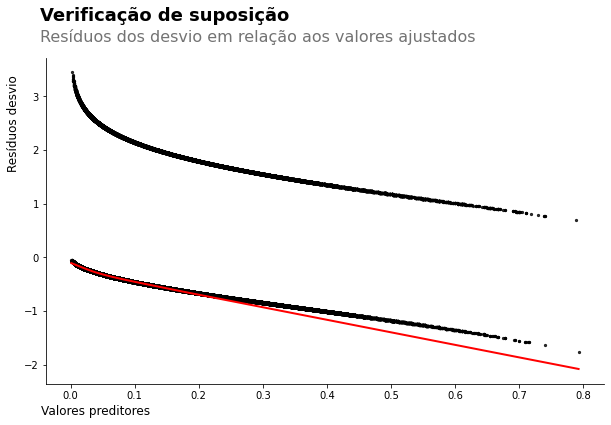

In [22]:
fig, axL = plt.subplots(figsize=(10, 6))
suptitle = 'Verificação de suposição'
title = 'Resíduos dos desvio em relação aos valores ajustados'

sns.regplot(X, 
            Y_deviance, 
            ax= axL, 
            color='black', 
            scatter_kws={'s': 5}, 
            line_kws={'color':'r', 'alpha':1, 'lw':2}, 
            lowess=True)

axL.text(x=-0.01, y=1.10, s=suptitle, color='black', fontsize=18, weight='bold', ha='left', va='bottom', transform=axL.transAxes)
axL.text(x=-0.01, y=1.05, s=title, color='#646464', fontsize=16, alpha=0.9, ha='left', transform=axL.transAxes)
axL.set_xlabel('Valores preditores', fontsize=12, x=0.089)
axL.set_ylabel('Resíduos desvio', fontsize=12, y=0.798)
sns.despine()
plt.grid(False)
plt.show()

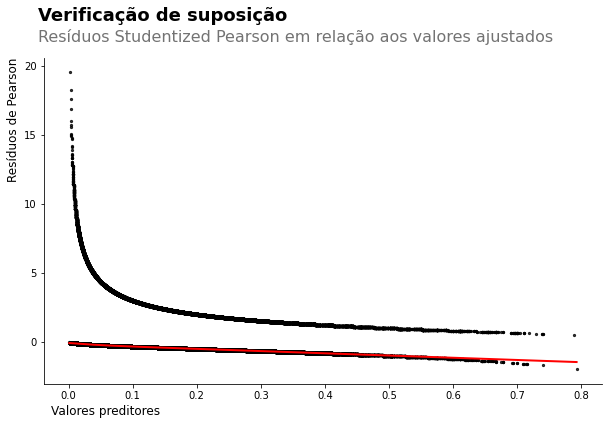

In [23]:
fig, axR = plt.subplots(figsize=(10, 6))
suptitle = 'Verificação de suposição'
title = 'Resíduos Studentized Pearson em relação aos valores ajustados'

sns.regplot(X, 
            Y_person,
            ax= axR,
            color='black', 
            scatter_kws={'s': 5},
            line_kws={'color':'r', 'alpha':1, 'lw':2}, 
            lowess=True)

axR.text(x=-0.01, y=1.10, s=suptitle, color='black', fontsize=18, weight='bold', ha='left', va='bottom', transform=axR.transAxes)
axR.text(x=-0.01, y=1.05, s=title, color='#646464', fontsize=16, alpha=0.9, ha='left', transform=axR.transAxes)
axR.set_xlabel('Valores preditores', fontsize=12, x=0.11)
axR.set_ylabel('Resíduos de Pearson', fontsize=12, y=0.81)
sns.despine()
plt.grid(False)
plt.show()

> <p style='text-align: justify;'>Parece que os gráficos se aproximam da linha horizontal com 0 interceptação, o que sugere que não há inadequação significativa do modelo.<font size=2.85></font></p>